## Connecting to the Database

In [1]:
pip install psycopg2-binary;

  Using cached psycopg2_binary-2.8.6-cp37-cp37m-manylinux1_x86_64.whl (3.0 MB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import psycopg2

In [3]:
# Put the password in 
PGHOST = 'tripdatabase2.cmaaautpgbsf.us-east-2.rds.amazonaws.com'
PGDATABASE = ''
PGUSER = 'postgres'
PGPASSWORD = 'Josh1234'

In [4]:
# Database Context Manager
try:   
    # Set up a connection to the postgres server.    
    conn = psycopg2.connect(user = PGUSER,
                            port = "5432",
                            password = PGPASSWORD,
                            host = PGHOST,
                            database = PGDATABASE)
    # Create a cursor object
    cursor = conn.cursor()   
    cursor.execute("SELECT version();")
    record = cursor.fetchone()
    print("Connection Success:", record,"\n")

except (Exception, psycopg2.Error) as error:
    print("Error while connecting to PostgreSQL", error)

Connection Success: ('PostgreSQL 12.5 on x86_64-pc-linux-gnu, compiled by gcc (GCC) 4.8.5 20150623 (Red Hat 4.8.5-11), 64-bit',) 



## Trip Table Cleaning I: Removing Outliers - Trip Duration
We will be using a basic definition of an outlier to determine which trips to remove based on their trip duration. An outlier will be defined as any value that is more than 3 times the standard deviation. The trip table has 111M rows in it so unfortunately we cannot directly take the mean and std of the tripduration column because it would take hours to execute. To overcome this we will use a sampling distribution to estimate the population mean and std.

In [5]:
# Possible Question: Evolution of ride length over time

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import Queries
import importlib

To get a feeling for how the trip duration values are distributed, let's sample 1M rows

In [7]:
sample_data = Queries.get_random_100k_rows(conn,shuffles=10)   # Get random samples 100K rows at a time

In [8]:
sample_data.tripduration.describe()

count    1000000.000000
mean          13.217048
std           10.839899
min            1.000000
25%            6.000000
50%           10.000000
75%           18.000000
max           96.000000
Name: tripduration, dtype: float64

The mean value of the trip duration column is 16m, but it has a standard deviation of 222m which is nearly 4 hours. Additionally, the 75 percentile of our data is 18m. It is clear that there are trips that are completely skewing our data. To put it in persective, if we use our original definition of an outlier then only trips over 12 hours would be considered outliers. Because the data is so heavily skewed the standard deviation is unreliable to help find outliers. The visualizatio below shows the data.

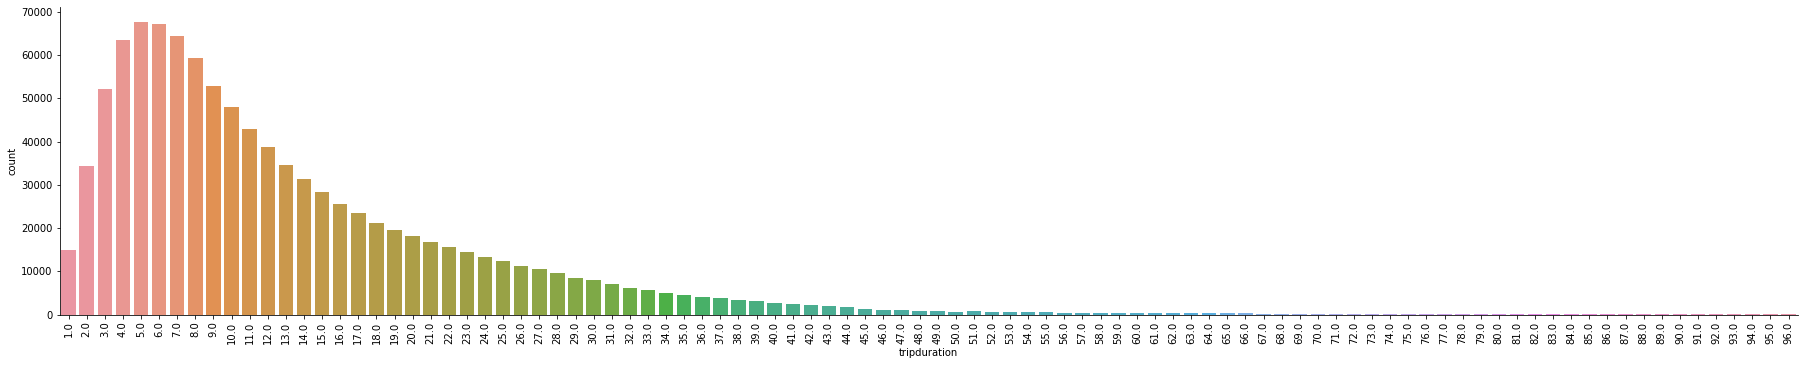

In [9]:
g = sns.catplot(x='tripduration', data=sample_data, kind='count', height=5, aspect=5)
g.set_xticklabels(rotation=90);

Our original outlier identification idea was based on the empirical rule that states 99.7% of data observed following a normal distribution lies within 3 standard deviations of the mean. Since our standard deviation is unreliable we will rip off the underlying idea behind the empirical rule, but with quantiles since they seem to be more representative of real life. Using quantiles, 99% of our data should be between the 0.5th and the 99.5th percentile. Anything above or below those percentile values will be considered outliers

In [10]:
sample_data.tripduration.quantile(0.005), sample_data.tripduration.quantile(0.995)

(1.0, 63.0)

Things to Mention
- All the trips that are slightly above 1.5 hrs aren't necessarily invalid trips. However, the trips that have a high likelihood of being invalid are above 1.5 hrs. Why? Citibike isn't a service targetted towards long distance rides, which can be seen in their pricing models. The annual membership allows unlimited rides that are capped at 45m. Their day pass allows unlimited rides that are capped at 30m. And a single ride is 3 for 30m. With these finacial thresholds in place, it makes sense why the majority of trips are beneath them. In fact, there is no incentive for a person to keep a bike out for significantly longer than the threshold. If you need the bike for 90m than an as annual rider you park the bike at 45m and then take another bike for the other 45m and not have to pay the extra 6.75 (unless you rode to a place where there aren't any stations to park or the stations have very limited bikes and you don't want to risk your bike being taken and being stranded).
- The data is 'sensitive' to quantile changes. Example the 99.5th quantile is 94m the 99th is 62m and the 98th is 46m.
- *Although there is only one sample of 1M rows taken, no matter how many times you sample from all the trips the lower quantile is 1 and the upper quantile is close to 96. The reason that I ommitted the many times I sampled was because sampling takes a long time to execute*

In [9]:
Queries.delete_duration_outliers(conn)

## Trip Table Cleaning II: Removing Time Errors - Start Time After End Time

Anytrip with a starttime that was greater than an endtime is an error and will get deleted. It is possible that the two values were just swapped. The cost of swapping them is more expensive than it is worth and it's better to just remove them. The operations of the swap are:
- Find the incorrect values
- Move them to a temporary table with the correct order
- Delete them from the original table
- Reinsert them 

In [74]:
data = Queries.find_time_swaps(conn)

In [75]:
data.shape

(201, 8)

From the first step there are barely over 200 incorrectly timed trips returned, continuing to the other steps isn't worth it for such little data. It's less expensive to delete them. 

In [12]:
Queries.delete_time_swaps(conn)

## Trip Table Cleaning III: Handling Outliers - Speed
In this section we are going to modify trips whose speed (MPH) are physically unlikely. Luckily, we have a reference from CitiBike on what a speed outlier might look like. According to them their pedal assisted e-bikes can go up to 18 MPH. In the sport of cycling, although not on a pedal assisted bike, a reasonably experienced cyclist can reach over 19 MPH. Using a nicer whole number, we'll use 20 MPH as a conservative cutoff and anything over that will be considered an outlier. 

In [93]:
sample_data = Queries.get_random_100k_rows(conn, speed=True, distance=True, shuffles=10)

We've already took the "delete data" path multiple times in this project. We deleted all the NJ trips, the trip duration outliers, and the invalid swaps. Although after all those deletes we still have tons of data (111M to 105M), let's make an effort to conserve data. To handle speed outliers, we are going to cap the speed at 20 MPH. Any trip that has a speed over 20 MPH we are going to adjust the trip duration in a way that when the speed is calculated it will result in 20 MPH. $$\frac{Distance}{\frac{Duration}{60}} = 20$$

$$\frac{60 \times Distance}{20} = 3 \times Distance = Duration$$

Based off the formula, we will have to find the trips whose speed is above 20 MPH and set it to 20 MPH, then update tripduration by multiplying the distance by 3. **Before we can do any of this we need to actually create the distance and speed column**. The 'trip' table doesn't have distance and speed columns so they have to be manufactured. It's more efficient to recreate the 'trip' table from scratch and add in the columns then to try to update the prexisting table. The new table with the distance and speed columns will be called 'trip_ds'

In [ ]:
Queries.recreate_trip()

In [ ]:
speed_outliers_query = """
            UPDATE trip_ds
               SET speed = 20,
                   tripduration = distance * 3
             WHERE speed > 20;
             """
Queries.execute_query(conn,speed_outliers_query)

We dealt with outliers on the upper end of speed. Now let's deal with values on the lower end up speed. The lower end is tricky because of round trips. Round trips are when a rider starts and ends at the same station. Because of this, those trips' distances are calculated as zero miles resulting in the speed also being zero. To determine whether or not a round trip was valid or not we have to take into consideration the duration of the trip. To fix these outliers two assumptions will be made.
- Assumption 1: A valid round trip has a minimum distance of 0.5 miles (0.25 each way). 
- Assumption 2: The rider was traveling at the mean speed value of 6 MPH **(mean after filtering out the 0 MPH trips)**

Combining both assumptions, a valid round trip should have a minimum trip duration of 5 minutes. Any trip that has a distance of 0 and a tripduration less than 5 we will set the tripduration to 5, set the speed to 6 MPH, and set the distance to 0.5 miles

In [ ]:
roundtrip_outliers_query = """
                UPDATE trip_ds
                   SET tripduration = 5,
                       distance = 0.5,
                       speed = 6
                 WHERE distance = 0 
                   AND tripduration < 5;
                 """
Queries.execute_query(conn, roundtrip_outliers_query)

## Trip Table Cleaning IV: Handling Outliers - Age 

In [25]:
sample_data = Queries.get_random_100k_rows(conn,shuffles=10)

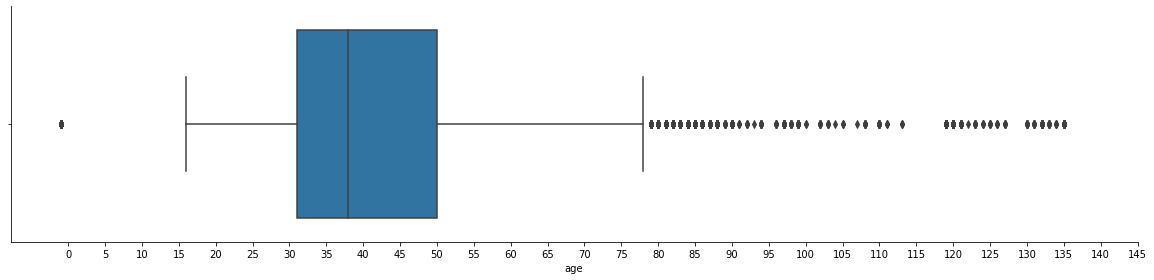

In [29]:
g = sns.catplot(x='age', data=sample_data, kind='box', height=4, aspect=4)
plt.xticks(np.arange(0,150, 5.0));

There is a big gap of data between the age range of 114-120. Why? I believe that data after the 115 year mark is dervived by the system accidently adding 100 years to the rider's actual age. My hypothesis is plausible because the the minimum age to use the service is 16 years old. If the systematic error is true then there shouldn't be data from 114-115 and very little data from 116-120. *The 'add 100" hypothesis doesn't work for data between 100 - 114 because the riders would be underage.*

In [18]:
minus_100_query = """
            UPDATE trip
               SET age = age - 100
             WHERE age > 114;
             """
Queries.execute_query(conn, minus_100_query)

In [19]:
minus_100_query_ds = """
            UPDATE trip_ds
               SET age = age - 100
             WHERE age > 114;
             """
Queries.execute_query(conn, minus_100_query_ds)

In [30]:
sample_data = Queries.get_random_100k_rows(conn,shuffles=10)

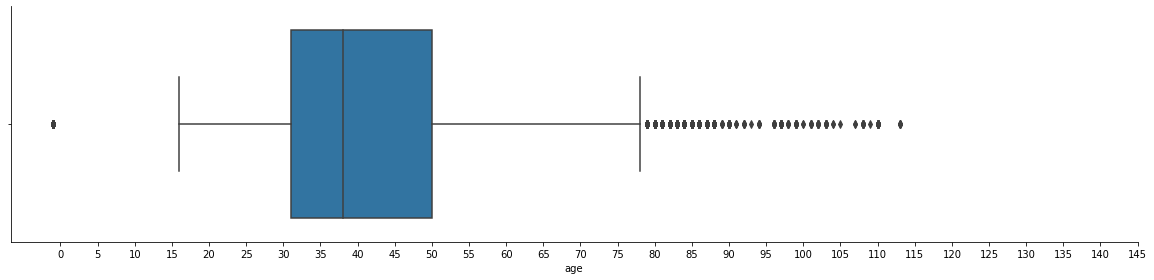

In [31]:
g = sns.catplot(x='age', data=sample_data, kind='box', height=4, aspect=4)
plt.xticks(np.arange(0,150, 5.0));

When it comes to the missing -1 data and the data beyond upper wiskher it's best to let sleeping dogs lie. Missing age data only occurs up to 2017, after 2017 the age value is available for every trip. Trying to input age data would potentially ruin any future analysis that is conditional on the age data. And outright deleting those rows will result in a lot of valuable trip data. Additionally, I don't know how we would fix those values that are above the 80 year old mark. In future notebooks anytime we do some sort of age filter we are going to use ages between 16 and 80. 

In [11]:
sample_data['age']= sample_data[(sample_data.age > 0) & (sample_data.age < 80)]
sample_data.replace(-1,np.nan,inplace=True)

In [ ]:
g = sns.catplot(x='age', data=sample_data, kind='count', height=4, aspect=4)
g.set_xticklabels(rotation=90)

## Station Table Update I: Station Status
The stations that exist in the system is always changing. CitiBike adds new stations, removes stations, and occasionally moves stations to nearby locations. In this section we are going to add two new columns to the 'station' table called birth and death. The birth column will represent the date of the first trip that was taken from the station. The death column represents the date of the last trip that was taken from the station. Stations are considered dead if there wasn't a trip within the last month. Any station that is still active will have a null value in the death column.

In [ ]:
add_columns_query = """
            ALTER TABLE station
            ADD COLUMN birth TIMESTAMP,
            ADD COLUMN death TIMESTAMP;
            """
Queries.execute_query(conn, add_columns_query)

In [ ]:
Queries.birth_certificate(conn)

In [ ]:
set_death_null = """
        UPDATE station
           SET death = NULL
         WHERE death <= '2020-12-31'
           AND death > '2020-12-01';
        """
Queries.execute_query(conn, set_death_null)